<font size="+12"><center>
    MVPA analysis: SVM
</font></center>

Author:
Egor Ananyev

# Preparation

## Loading packages

In [1]:
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
import os

In [2]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [3]:
mne.set_log_level('warning')  # less verbose output

## Setting parameters

In [4]:
interactive = False  # Whether to render interactive figures such as channel plots
# ...should be set to True on first pass

debug = False

cur_subj = 1
numof_runs = 7  # TEMP; is 7 for subj 01

## Loading evoked data

In [5]:
# data_path = os.path.expanduser("C:\\Users\\egora\\Downloads\\meg\\")
data_path = os.path.expanduser('E:\\meg\\')

cur_subj_str = str(cur_subj).zfill(2)

for cur_run in range(numof_runs):
    cur_run_str = str(cur_run+1).zfill(2)
    fname = os.path.join(data_path,
                             'derivatives\\meg_derivatives\\sub-' + cur_subj_str + '\\ses-meg\\meg\\sub-' + \
                             cur_subj_str + '_ses-meg_experimental_run-' + cur_run_str + '_proc-sss_300_epo.fif')
    print(fname)
    epochs_run = mne.read_epochs(fname)
    # example append: https://www.programcreek.com/python/example/92634/mne.Epochs
    epochs_run = epochs_run.pick_types(meg=True)
    epochs_run_df = epochs_run.to_data_frame()
    # Normalizing the signal by the baseline:
    epochs_run_std = epochs_run_df.sort_index(level=['condition', 'epoch', 'time'], ascending=[1, 1, 1])
    epochs_run_std = epochs_run_std.loc[pd.IndexSlice[:, :, -100:-1], :].groupby(['condition', 'epoch']).std()
    epochs_run_norm = epochs_run_df / epochs_run_std
    if cur_run == 0:
        epochs_df = epochs_run_norm
    else: 
        epochs_df = epochs_df.append(epochs_run_norm)

E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-01_proc-sss_300_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-02_proc-sss_300_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-03_proc-sss_300_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-04_proc-sss_300_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-05_proc-sss_300_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-06_proc-sss_300_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-07_proc-sss_300_epo.fif


In [6]:
np.shape(epochs_df)

(212477, 306)

In [7]:
epochs_df.columns

Index(['MEG0111', 'MEG0112', 'MEG0113', 'MEG0121', 'MEG0122', 'MEG0123',
       'MEG0131', 'MEG0132', 'MEG0133', 'MEG0141',
       ...
       'MEG2613', 'MEG2621', 'MEG2622', 'MEG2623', 'MEG2631', 'MEG2632',
       'MEG2633', 'MEG2641', 'MEG2642', 'MEG2643'],
      dtype='object', name='channel', length=306)

In [8]:
epochs_df.index

MultiIndex([( 'left/dur1/cont017',  0, -100),
            ( 'left/dur1/cont017',  0,  -97),
            ( 'left/dur1/cont017',  0,  -93),
            ( 'left/dur1/cont017',  0,  -90),
            ( 'left/dur1/cont017',  0,  -87),
            ( 'left/dur1/cont017',  0,  -83),
            ( 'left/dur1/cont017',  0,  -80),
            ( 'left/dur1/cont017',  0,  -77),
            ( 'left/dur1/cont017',  0,  -73),
            ( 'left/dur1/cont017',  0,  -70),
            ...
            ('right/dur4/cont100', 80,  570),
            ('right/dur4/cont100', 80,  573),
            ('right/dur4/cont100', 80,  577),
            ('right/dur4/cont100', 80,  580),
            ('right/dur4/cont100', 80,  583),
            ('right/dur4/cont100', 80,  587),
            ('right/dur4/cont100', 80,  590),
            ('right/dur4/cont100', 80,  593),
            ('right/dur4/cont100', 80,  597),
            ('right/dur4/cont100', 80,  600)],
           names=['condition', 'epoch', 'time'], length=212477)

In [9]:
epochs_df

channel                         MEG0111   MEG0112   MEG0113   MEG0121  \
condition          epoch time                                           
left/dur1/cont017  0     -100  1.576067 -1.029522  0.571275  0.491981   
                         -97   0.553957  1.626679 -0.112674 -0.431652   
                         -93  -0.279769  2.322377 -0.267687 -1.575911   
                         -90   0.522749  0.226120  0.893295 -1.309778   
                         -87   0.293753  0.441796  0.232567 -0.783006   
...                                 ...       ...       ...       ...   
right/dur4/cont100 80     587 -0.167930 -1.786224 -3.949863  2.572864   
                          590 -0.474831  0.427726 -4.605781  2.374211   
                          593 -0.942890  1.387941 -4.254599  1.293214   
                          597 -0.754338 -0.794540 -3.232324  1.486582   
                          600 -0.628704 -0.707739 -3.467270  1.626736   

channel                         MEG0122   MEG0123   MEG0131   MEG0132  \
condition          epoch time                                           
left/dur1/cont017  0     -100  1.058599 -0.493659  0.663217  0.705375   
                         -97   0.518709  0.751502  0.000823  0.841055   
                         -93   0.892310  0.535878 -0.401346  1.689365   
                         -90   1.095882 -0.012185 -0.096783  1.585785   
                         -87   1.216999  0.366995 -0.292678  0.982597   
...                                 ...       ...       ...       ...   
right/dur4/cont100 80     587 -0.568288 -1.272248  0.698832 -0.696469   
                          590 -2.004040 -0.308461  0.481093 -0.424927   
                          593 -2.234754 -0.672880 -0.247038  0.638557   
                          597 -1.446546 -1.652420 -0.627605  0.637537   
                          600 -1.763028 -1.177448 -0.554681  0.485943   

channel                         MEG0133   MEG0141  ...   MEG2613   MEG2621  \
condition          epoch time                      ...                       
left/dur1/cont017  0     -100 -0.142850  0.806979  ...  1.566507 -0.320609   
                         -97   0.164376  0.925319  ...  1.852537  0.701891   
                         -93   1.405414  0.939116  ...  1.718926  1.992536   
                         -90   1.705368  0.958678  ...  1.127426  0.694928   
                         -87   1.250537  0.805790  ...  1.220103  0.344151   
...                                 ...       ...  ...       ...       ...   
right/dur4/cont100 80     587 -2.553035 -0.457694  ... -4.023089  0.223301   
                          590 -2.576332 -0.439530  ... -3.812698  0.246519   
                          593 -1.360856 -0.768171  ... -3.168895  0.041388   
                          597 -2.971802 -0.941390  ... -3.041159  0.223355   
                          600 -3.810544 -0.852254  ... -3.120419  0.565635   

channel                         MEG2622   MEG2623   MEG2631   MEG2632  \
condition          epoch time                                           
left/dur1/cont017  0     -100  1.098164 -0.568150 -0.681471  0.436580   
                         -97   1.580174  1.762313  0.305857  0.453597   
                         -93   1.525474  1.623664  1.588214  1.504487   
                         -90   0.967500 -1.416325  0.141986  1.843892   
                         -87   0.157583 -0.593685  0.242331  0.891950   
...                                 ...       ...       ...       ...   
right/dur4/cont100 80     587 -1.035666  1.615875  0.390150  0.163755   
                          590 -1.153710  1.372623  0.536086 -0.088942   
                          593 -1.678995  1.903183  0.600947 -0.834262   
                          597 -2.236237  1.978202  1.009804 -0.769130   
                          600 -2.088028  1.867654  1.373922 -0.603343   

channel                         MEG2633   MEG2641   MEG2642   MEG2643  
condition          epoch time                                  

In [10]:
all_times = np.round(epochs_run.times * 1000).astype(int)
# print(all_times)
print(np.shape(all_times))

(211,)


The path to store MVPA-related data and visualization.

In [11]:
mvpa_path = os.path.join(data_path, 'derivatives\\meg_derivatives\\sub-' + cur_subj_str + '\\ses-meg\\meg-mvpa\\')
mvpa_fname = os.path.join(mvpa_path, 'sub-' + cur_subj_str)
print(mvpa_fname)

E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg-mvpa\sub-01


## Examining raw data

In [12]:
%matplotlib qt
if interactive:
    raw.plot()

# Support Vector Machines

## Logic of SVM-based classification

In [13]:
## In principle (from https://scikit-learn.org/stable/modules/svm.html):
X = [[0, 0], [1, 1], [2, 2]]  # channel measurements [n_features] on all but one trial [n_samples] at time t
y = [0, 1, 1]                 # stimulus orientation with length [n_samples]
clf = svm.LinearSVC()         # linear Support Vector Classification
clf.fit(X, y)                 # model fitting
clf.predict([[3, 3]])         # model testing on the remaining trial at time t

array([1])

In [14]:
np.shape(X)  # array of size [n_samples, n_features]

(3, 2)

## SVM routine

In [15]:
# This suppresses the sklearn warnings
# def warn(*args, **kwargs):
#     pass
# import warnings
# warnings.warn = warn

In [15]:
def run_svm(X_, y_, kernel_='sigmoid', n_splits=10, track=True):
    acc_list = []
    ss = ShuffleSplit(n_splits=n_splits, test_size=0.2)
    for train_index, test_index in ss.split(X_):
        X_train = X_[train_index]
        y_train = y_[train_index]
        X_test = X_[test_index]
        y_test = y_[test_index]
        clf = svm.SVC(C=0.1, kernel=kernel_, gamma=0.001, cache_size=2000).fit(X_train, y_train)
    #     clf = svm.SVR(cache_size=2000).fit(X_train, y_train)  # won't work with accuracy_score
    #     scores = cross_val_score(clf, X_train, y_train, cv=4)
    #     print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        y_pred = clf.predict(X_test)
    #     print(classification_report(y_test, y_pred))
        this_acc = accuracy_score(y_test, y_pred)
        acc_list.append(this_acc)
    #     print(accuracy_score(y_test, y_pred))
    if track:
        print('{0:.2f}'.format(np.mean(acc_list)), end=' ')
    return np.mean(acc_list), np.std(acc_list)

## Iterating through _t_

In [16]:
def iter_times(all_times_, epochs_subset_df_, kernel='sigmoid', n_splits=10, track=True):  #, validate=False):
    acc_mean = []
    acc_sd = []
    counter = 0
    print('[', end=' ')
    for t in all_times_:
        if (counter == int(len(all_times)/10)):
            print('||', end=' ')
            counter = 0
        counter += 1
#         X_right = epochs_subset_df_.loc[('right/'+cur_cond_str_, slice(None), t), :].values
#         X_left = epochs_subset_df_.loc[('left/'+cur_cond_str_, slice(None), t), :].values
        X_right = epochs_subset_df_[epochs_subset_df_.index.get_level_values('condition').str.contains('right')].loc[pd.IndexSlice[:, :, t], :]
        X_left = epochs_subset_df_[epochs_subset_df_.index.get_level_values('condition').str.contains('left')].loc[pd.IndexSlice[:, :, t], :]
        X = np.concatenate((X_right, X_left))
        y = np.concatenate((np.repeat(1, len(X_right)), np.repeat(0, len(X_left))))
        acc_this_mean, acc_this_sd = run_svm(X, y, kernel_=kernel, n_splits=n_splits, track=track)
        acc_mean.append(acc_this_mean)
        acc_sd.append(acc_this_sd)
    print(']')
    return acc_mean, acc_sd

# Combining all conditions

In [17]:
acc = pd.DataFrame(np.zeros((1, len(all_times))), columns=all_times)
acc_sd = pd.DataFrame(np.zeros((1, len(all_times))), columns=all_times)
cur_acc_mean, cur_acc_sd = iter_times(all_times, epochs_df, track=True, n_splits=2)  #, validate=False)
acc.loc[0, :] = cur_acc_mean
acc_sd.loc[0, :] = cur_acc_sd

[ 0.49 0.47 0.50 0.49 0.45 0.48 0.47 0.49 0.48 0.48 0.46 0.49 0.48 0.48 0.49 0.45 0.47 0.46 0.48 0.48 0.46 || 0.48 0.49 0.48 0.50 0.49 0.44 0.46 0.48 0.47 0.48 0.50 0.50 0.47 0.51 0.47 0.48 0.48 0.48 0.43 0.47 0.47 || 0.51 0.46 0.52 0.53 0.50 0.55 0.48 0.50 0.44 0.50 0.52 0.50 0.48 0.56 0.57 0.59 0.52 0.50 0.47 0.45 0.47 || 0.51 0.50 0.53 0.53 0.45 0.52 0.54 0.54 0.57 0.53 0.51 0.48 0.52 0.52 0.52 0.50 0.47 0.49 0.47 0.48 0.47 || 0.43 0.44 0.47 0.49 0.46 0.48 0.46 0.47 0.46 0.45 0.49 0.48 0.47 0.47 0.49 0.48 0.46 0.48 0.46 0.48 0.46 || 0.48 0.54 0.51 0.51 0.46 0.48 0.48 0.51 0.48 0.48 0.45 0.46 0.45 0.49 0.50 0.46 0.49 0.51 0.50 0.52 0.51 || 0.49 0.48 0.46 0.46 0.48 0.46 0.44 0.48 0.52 0.46 0.45 0.46 0.49 0.52 0.47 0.45 0.47 0.47 0.48 0.46 0.47 || 0.46 0.45 0.46 0.49 0.48 0.43 0.47 0.50 0.49 0.48 0.49 0.49 0.52 0.49 0.56 0.45 0.50 0.49 0.45 0.49 0.49 || 0.55 0.48 0.47 0.48 0.47 0.49 0.49 0.48 0.51 0.48 0.46 0.46 0.48 0.48 0.50 0.50 0.46 0.46 0.49 0.47 0.49 || 0.48 0.52 0.51 0.44 0.51 0

In [ ]:
acc.to_csv(mvpa_fname + '_acc_sigmoid_all.csv')

In [28]:
print(np.shape(acc_sd.to_numpy().flatten()))
acc_sd.to_numpy()

(211,)


array([[0.01485149, 0.00742574, 0.0049505 , 0.01237624, 0.03960396,
        0.00247525, 0.02475248, 0.01237624, 0.01732673, 0.0049505 ,
        0.03960396, 0.00990099, 0.01980198, 0.00247525, 0.01237624,
        0.01485149, 0.01237624, 0.02475248, 0.00247525, 0.00990099,
        0.02970297, 0.01237624, 0.00247525, 0.02475248, 0.00742574,
        0.01485149, 0.02970297, 0.00247525, 0.02227723, 0.00990099,
        0.        , 0.01980198, 0.01485149, 0.02970297, 0.00247525,
        0.00742574, 0.00742574, 0.03960396, 0.00990099, 0.02475248,
        0.01732673, 0.01485149, 0.02722772, 0.01485149, 0.02227723,
        0.01980198, 0.        , 0.01237624, 0.02475248, 0.00742574,
        0.03465347, 0.00247525, 0.02475248, 0.01980198, 0.        ,
        0.02722772, 0.00247525, 0.01485149, 0.01237624, 0.02970297,
        0.        , 0.00742574, 0.01732673, 0.03217822, 0.0049505 ,
        0.        , 0.01980198, 0.01485149, 0.04455446, 0.00742574,
        0.01732673, 0.01237624, 0.01485149, 0.00

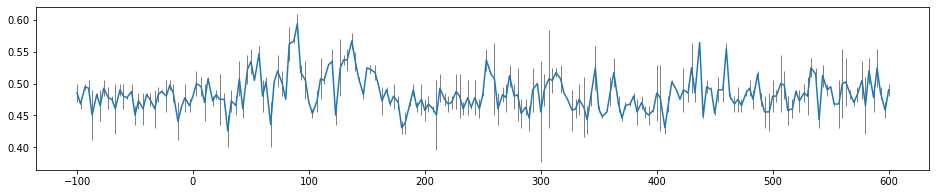

In [32]:
%matplotlib inline
plt.figure(figsize=(16, 3))
# plt.plot(all_times, np.array(acc.T));
plt.errorbar(all_times, np.array(acc.T), yerr=acc_sd.to_numpy().flatten(), ecolor='gray', elinewidth=1)
plt.savefig(mvpa_fname + '_sigmoid_sd' + '.pdf')
# leg = plt.legend(loc='lower left', ncol=4, shadow=True, fancybox=True)
# leg.get_frame().set_alpha(0.8)

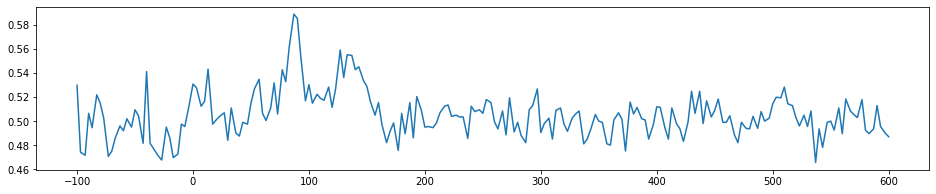

In [81]:
%matplotlib inline
plt.figure(figsize=(16, 3))
plt.plot(all_times, np.array(acc.T));
# plt.savefig(qc_fname + '_light-sensors.pdf')
# leg = plt.legend(loc='lower left', ncol=4, shadow=True, fancybox=True)
# leg.get_frame().set_alpha(0.8)

# Combining all conditions (no SD)

In [113]:
acc = pd.DataFrame(np.zeros((1, len(all_times))), columns=all_times)
acc_sd = pd.DataFrame(np.zeros((1, len(all_times))), columns=all_times)
cur_acc_mean, cur_acc_sd = iter_times(all_times, epochs_df, track=True, n_splits=2)  #, validate=False)
acc.loc[0, :] = cur_acc_mean
acc_sd.loc[0, :] = cur_acc_sd

[ 0.52 0.49 0.48 0.51 0.50 0.53 0.52 0.50 0.47 0.47 0.49 0.49 0.50 0.51 0.49 0.51 0.49 0.49 0.51 0.49 0.48 || 0.48 0.48 0.49 0.48 0.47 0.48 0.49 0.49 0.51 0.52 0.53 0.52 0.51 0.53 0.51 0.51 0.50 0.51 0.48 0.49 0.49 || 0.48 0.49 0.51 0.52 0.53 0.53 0.52 0.51 0.50 0.53 0.52 0.52 0.54 0.55 0.58 0.59 0.54 0.52 0.52 0.51 0.53 || 0.52 0.51 0.54 0.51 0.53 0.55 0.53 0.55 0.55 0.56 0.55 0.53 0.52 0.52 0.51 0.50 0.50 0.50 0.48 0.49 0.48 || 0.50 0.49 0.49 0.50 0.50 0.50 0.50 0.49 0.50 0.50 0.51 0.50 0.49 0.49 0.49 0.51 0.51 0.50 0.51 0.51 0.50 || 0.51 0.50 0.50 0.49 0.49 0.49 0.51 0.51 0.51 0.50 0.50 0.50 0.51 0.50 0.50 0.50 0.50 0.50 0.51 0.51 0.50 || 0.50 0.49 0.50 0.50 0.50 0.49 0.49 0.49 0.49 0.50 0.49 0.49 0.50 0.51 0.50 0.49 0.50 0.50 0.49 0.49 0.50 || 0.50 0.50 0.49 0.50 0.50 0.51 0.50 0.50 0.50 0.50 0.50 0.50 0.49 0.50 0.50 0.50 0.50 0.49 0.50 0.49 0.49 || 0.50 0.50 0.50 0.49 0.50 0.50 0.50 0.49 0.50 0.50 0.50 0.50 0.50 0.49 0.50 0.51 0.50 0.50 0.50 0.50 0.51 || 0.50 0.50 0.50 0.50 0.50 0

In [ ]:
acc.to_csv(mvpa_fname + '_acc_sigmoid_all.csv')

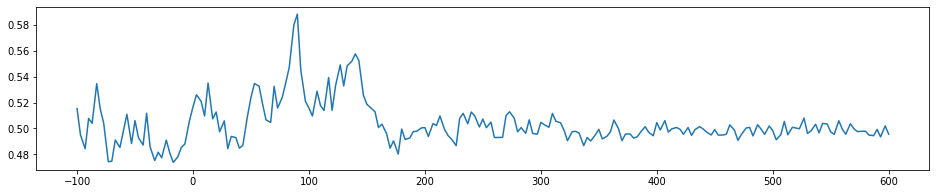

In [114]:
%matplotlib inline
plt.figure(figsize=(16, 3))
plt.plot(all_times, np.array(acc.T));
plt.savefig(mvpa_fname + '_sigmoid' + str(all_durs[cur_dur]) + '.pdf')
# leg = plt.legend(loc='lower left', ncol=4, shadow=True, fancybox=True)
# leg.get_frame().set_alpha(0.8)

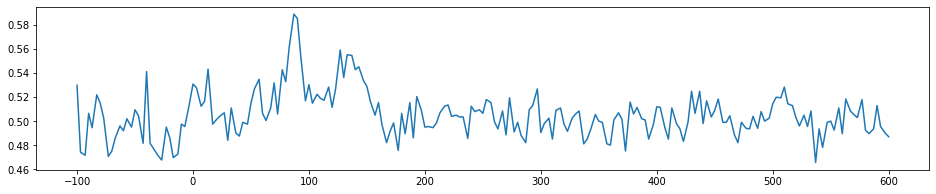

In [81]:
%matplotlib inline
plt.figure(figsize=(16, 3))
plt.plot(all_times, np.array(acc.T));
# plt.savefig(qc_fname + '_light-sensors.pdf')
# leg = plt.legend(loc='lower left', ncol=4, shadow=True, fancybox=True)
# leg.get_frame().set_alpha(0.8)

# Combining all: RBF kernel

In [23]:
acc = pd.DataFrame(np.zeros((1, len(all_times))), columns=all_times)
cur_acc = iter_times(all_times, epochs_df, kernel='rbf', track=True, n_splits=100)  #, validate=False)
acc.loc[0, :] = cur_acc

[ 0.48 0.47 0.47 0.48 0.47 0.47 0.48 0.48 0.48 0.48 0.48 0.47 0.47 0.47 0.48 0.48 0.48 0.48 0.48 0.48 0.48 || 0.47 0.47 0.48 0.48 0.48 0.47 0.47 0.48 0.47 0.47 0.48 0.47 0.48 0.48 0.47 0.47 0.47 0.48 0.48 0.47 0.47 || 0.47 0.48 0.47 0.47 0.50 0.51 0.48 0.48 0.47 0.48 0.49 0.47 0.48 0.48 0.51 0.51 0.48 0.47 0.47 0.47 0.47 || 0.47 0.47 0.48 0.48 0.48 0.49 0.49 0.49 0.50 0.50 0.49 0.48 0.47 0.47 0.47 0.47 0.48 0.48 0.47 0.48 0.48 || 0.47 0.48 0.47 0.47 0.48 0.47 0.48 0.48 0.47 0.48 0.48 0.47 0.48 0.47 0.48 0.47 0.48 0.47 0.47 0.48 0.48 || 0.48 0.47 0.48 0.47 0.48 0.48 0.47 0.48 0.48 0.47 0.48 0.47 0.47 0.47 0.48 0.47 0.48 0.48 0.47 0.48 0.47 || 0.48 0.48 0.47 0.47 0.47 0.48 0.47 0.47 0.47 0.48 0.47 0.48 0.47 0.48 0.47 0.48 0.47 0.47 0.48 0.48 0.47 || 0.48 0.47 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.47 0.48 0.48 0.48 0.48 0.47 0.47 0.47 0.47 0.48 0.47 || 0.48 0.48 0.47 0.48 0.48 0.48 0.48 0.47 0.48 0.47 0.47 0.48 0.48 0.48 0.48 0.48 0.47 0.47 0.47 0.48 0.48 || 0.47 0.48 0.48 0.48 0.47 0

In [24]:
acc.to_csv(mvpa_fname + '_acc_rbf_all.csv')

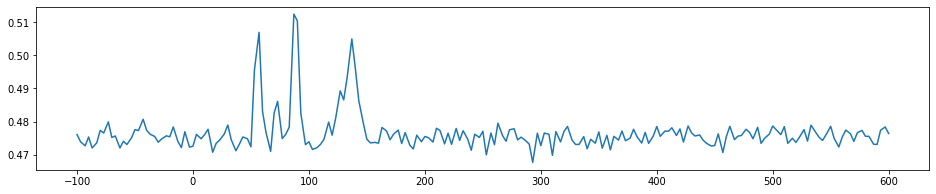

In [26]:
%matplotlib inline
plt.figure(figsize=(16, 3))
plt.plot(all_times, np.array(acc.T));
plt.savefig(mvpa_fname + '_rbf_all' + '.pdf')
# leg = plt.legend(loc='lower left', ncol=4, shadow=True, fancybox=True)
# leg.get_frame().set_alpha(0.8)

# Iterating through contrasts

In [115]:
all_conts = [17, 33, 50, 100]
acc = pd.DataFrame(np.zeros((len(all_conts), len(all_times))), index=all_conts, columns=all_times)
for cur_cont in range(len(all_conts)):
    cur_cond_str = 'cont' + str(all_conts[cur_cont]).zfill(3)
    print(cur_cond_str, end=' ')
    epochs_subset_df = epochs_df[epochs_df.index.get_level_values('condition').str.contains(cur_cond_str)]
    cur_acc = iter_times(all_times, epochs_subset_df, track=False, n_splits=100)  #, cur_cond_str)
    acc.loc[(all_conts[cur_cont]), :] = cur_acc

cont017 [ 0.49 0.47 0.45 0.48 0.52 0.55 0.50 0.48 0.47 0.43 0.43 0.42 0.47 0.54 0.53 0.51 0.53 0.51 0.55 0.59 0.48 || 0.45 0.51 0.56 0.53 0.47 0.49 0.50 0.46 0.53 0.54 0.52 0.55 0.54 0.52 0.50 0.49 0.48 0.46 0.50 0.48 0.44 || 0.48 0.50 0.53 0.54 0.57 0.55 0.52 0.47 0.47 0.50 0.52 0.53 0.53 0.55 0.57 0.54 0.53 0.52 0.49 0.48 0.49 || 0.51 0.50 0.50 0.48 0.52 0.51 0.47 0.53 0.49 0.47 0.49 0.52 0.49 0.49 0.53 0.48 0.47 0.51 0.51 0.46 0.47 || 0.52 0.51 0.51 0.46 0.50 0.52 0.41 0.46 0.50 0.48 0.50 0.52 0.54 0.53 0.55 0.55 0.52 0.48 0.50 0.54 0.52 || 0.47 0.45 0.44 0.44 0.46 0.46 0.46 0.47 0.47 0.49 0.50 0.51 0.48 0.48 0.51 0.52 0.49 0.52 0.51 0.51 0.49 || 0.50 0.49 0.51 0.52 0.44 0.45 0.43 0.44 0.49 0.50 0.49 0.45 0.46 0.48 0.50 0.49 0.46 0.44 0.48 0.48 0.48 || 0.50 0.51 0.49 0.48 0.48 0.48 0.49 0.47 0.47 0.48 0.52 0.49 0.49 0.50 0.54 0.52 0.50 0.52 0.52 0.50 0.48 || 0.48 0.47 0.50 0.49 0.50 0.49 0.49 0.48 0.50 0.50 0.48 0.50 0.51 0.49 0.49 0.47 0.49 0.48 0.50 0.49 0.49 || 0.49 0.48 0.51 0.4

In [116]:
acc.to_csv(mvpa_fname + '_acc_sigmoid_cont.csv')

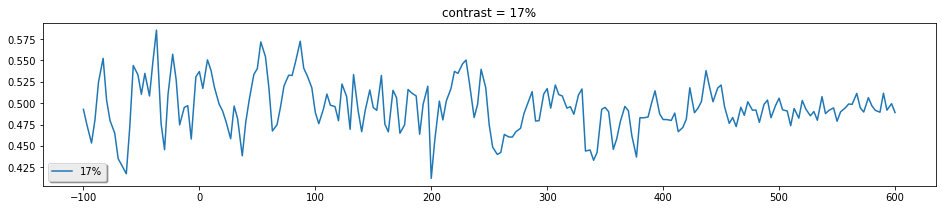

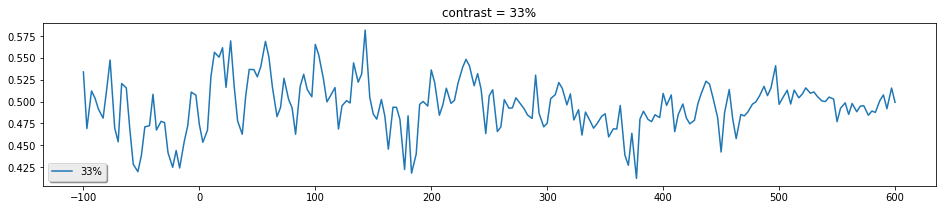

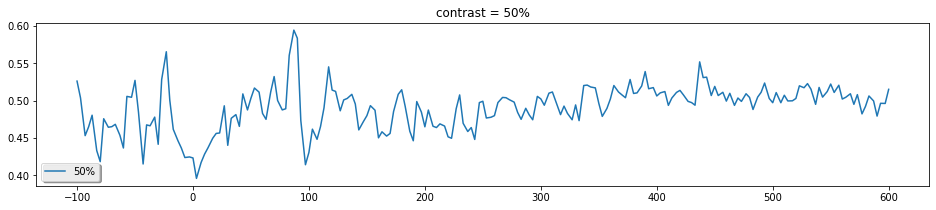

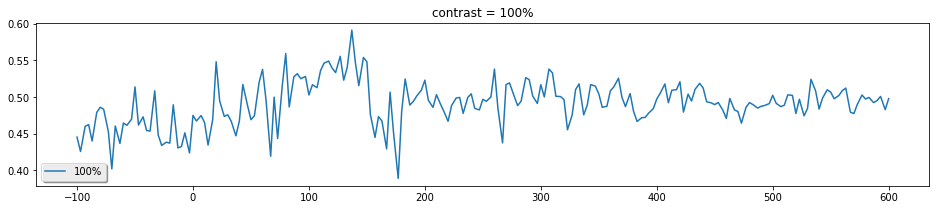

In [117]:
%matplotlib inline
for cur_cont in range(len(all_conts)):
    plt.figure(figsize=(16, 3))
    plt.title(label='contrast = ' + str(all_conts[cur_cont]) + '%')
    plt.plot(all_times, np.array(acc.loc[(all_conts[cur_cont]), :]).T, label = str(all_conts[cur_cont]) + '%');
    plt.savefig(mvpa_fname + '_sigmoid_cont' + str(all_conts[cur_cont]) + '.pdf')
    leg = plt.legend(loc='lower left', ncol=4, shadow=True, fancybox=True)
    leg.get_frame().set_alpha(0.8)

# Iterating through durations

In [118]:
all_durs = [1, 2, 3, 4]
acc = pd.DataFrame(np.zeros((len(all_durs), len(all_times))), index=all_durs, columns=all_times)
for cur_dur in range(len(all_durs)):
    cur_cond_str = 'dur' + str(all_durs[cur_dur])
    print(cur_cond_str, end=' ')
    epochs_subset_df = epochs_df[epochs_df.index.get_level_values('condition').str.contains(cur_cond_str)]
    cur_acc = iter_times(all_times, epochs_subset_df, track=False, n_splits=100)  #, cur_cond_str)
    acc.loc[(all_durs[cur_dur]), :] = cur_acc

dur1 [ 0.55 0.51 0.51 0.53 0.49 0.53 0.55 0.50 0.46 0.48 0.50 0.53 0.53 0.51 0.46 0.47 0.49 0.45 0.53 0.50 0.55 || 0.56 0.50 0.51 0.46 0.44 0.45 0.49 0.47 0.51 0.48 0.51 0.52 0.47 0.48 0.48 0.51 0.49 0.52 0.52 0.52 0.55 || 0.50 0.51 0.51 0.53 0.57 0.53 0.45 0.42 0.46 0.46 0.49 0.52 0.53 0.51 0.53 0.51 0.50 0.52 0.46 0.46 0.50 || 0.43 0.45 0.49 0.46 0.47 0.47 0.46 0.51 0.54 0.51 0.51 0.50 0.51 0.53 0.54 0.51 0.49 0.44 0.44 0.43 0.46 || 0.47 0.45 0.43 0.46 0.48 0.45 0.46 0.41 0.45 0.47 0.46 0.45 0.43 0.47 0.50 0.48 0.46 0.49 0.49 0.50 0.48 || 0.50 0.49 0.49 0.51 0.49 0.51 0.52 0.51 0.52 0.48 0.50 0.49 0.47 0.49 0.52 0.53 0.53 0.53 0.54 0.56 0.54 || 0.53 0.50 0.50 0.50 0.49 0.48 0.50 0.51 0.49 0.48 0.48 0.49 0.49 0.50 0.50 0.49 0.50 0.50 0.49 0.51 0.51 || 0.49 0.50 0.53 0.50 0.51 0.50 0.50 0.50 0.48 0.51 0.52 0.50 0.51 0.50 0.49 0.50 0.49 0.51 0.49 0.49 0.49 || 0.50 0.49 0.47 0.48 0.50 0.48 0.50 0.49 0.49 0.52 0.52 0.50 0.52 0.50 0.49 0.50 0.50 0.51 0.49 0.49 0.50 || 0.47 0.49 0.49 0.49 0

In [119]:
acc.to_csv(mvpa_fname + '_acc_sigmoid_dur.csv')

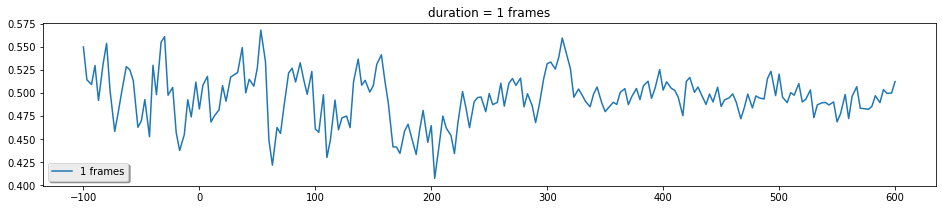

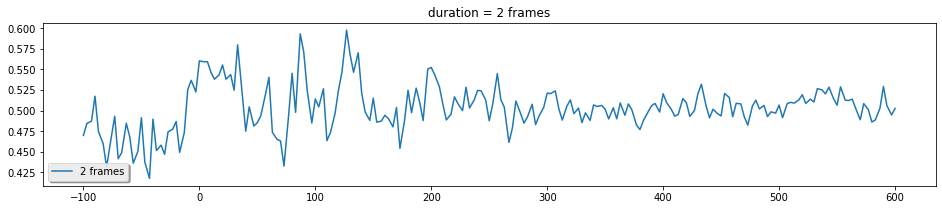

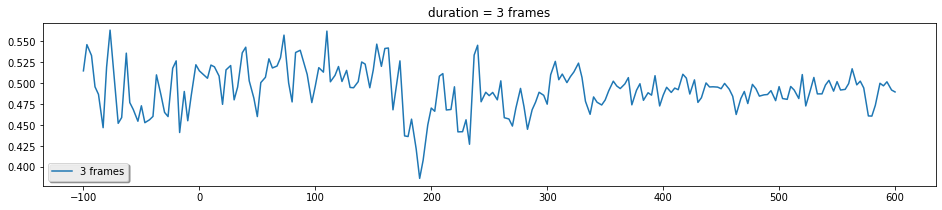

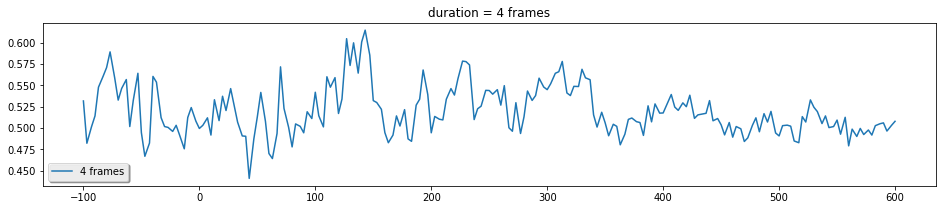

In [120]:
%matplotlib inline
for cur_dur in range(len(all_durs)):
    plt.figure(figsize=(16, 3))
    plt.title(label='duration = ' + str(all_durs[cur_dur]) + ' frames')
    plt.plot(all_times, np.array(acc.loc[(all_durs[cur_dur]), :]).T, label = str(all_durs[cur_dur]) + ' frames');
    plt.savefig(mvpa_fname + '_sigmoid_dur' + str(all_durs[cur_dur]) + '.pdf')
    leg = plt.legend(loc='lower left', ncol=4, shadow=True, fancybox=True)
    leg.get_frame().set_alpha(0.8)

# All conditions separate

In [ ]:
all_durs = [1, 2, 3, 4]
all_conts = [17, 33, 50, 100]
acc_index = pd.MultiIndex.from_product([all_durs, all_conts], names=['dur', 'cont'])
acc = pd.DataFrame(np.zeros((len(all_durs)*len(all_conts), len(all_times))),
                   index=acc_index, columns=all_times)
for cur_dur in range(len(all_durs)):
    for cur_cont in range(len(all_conts)):
        cur_cond_str = 'dur' + str(all_durs[cur_dur]) + '/' + 'cont' + str(all_conts[cur_cont]).zfill(3)
        print(cur_cond_str, end=' ')
        epochs_subset_df = epochs_df[epochs_df.index.get_level_values('condition').str.contains(cur_cond_str)]
        cur_acc = iter_times(all_times, epochs_subset_df, n_splits=100, track=False)  #, cur_cond_str)
        acc.loc[(all_durs[cur_dur], all_conts[cur_cont]), :] = cur_acc

In [126]:
# acc.to_csv(mvpa_fname + '_acc.csv')

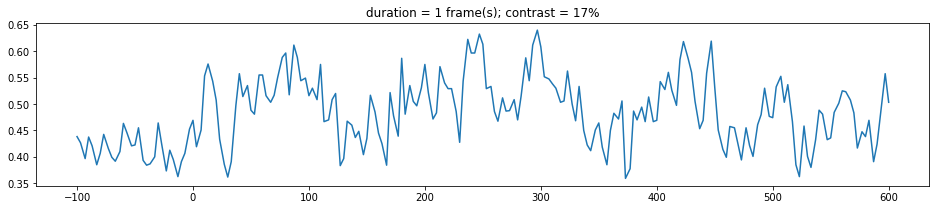

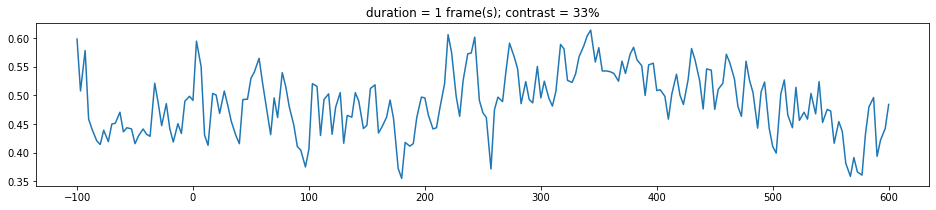

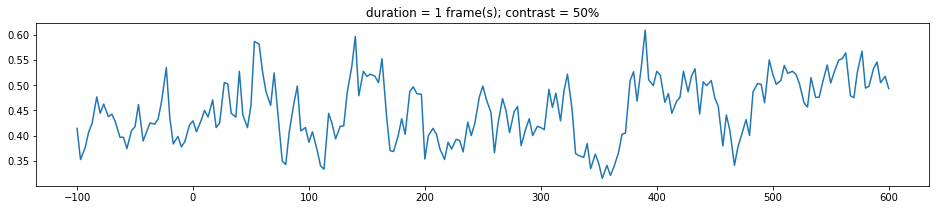

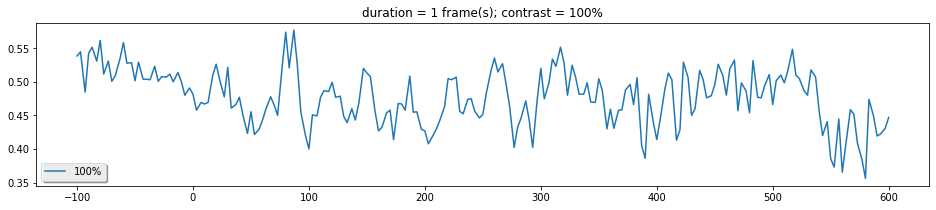

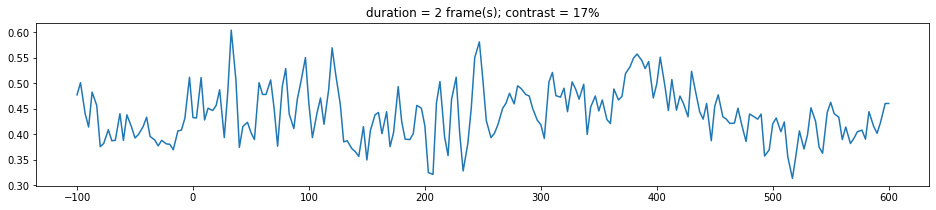

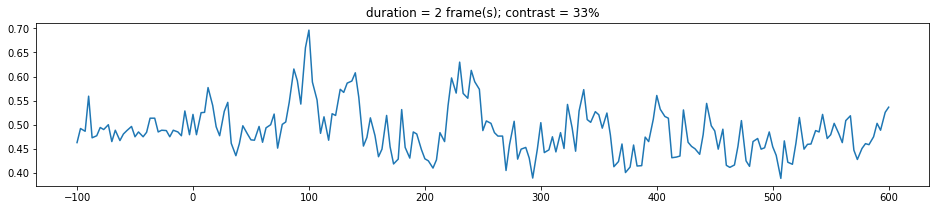

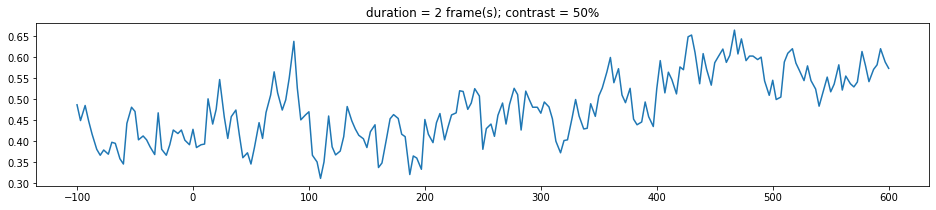

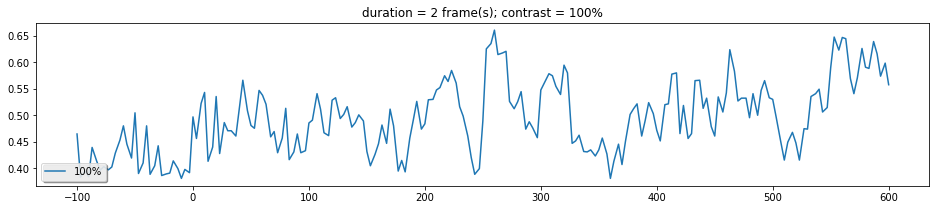

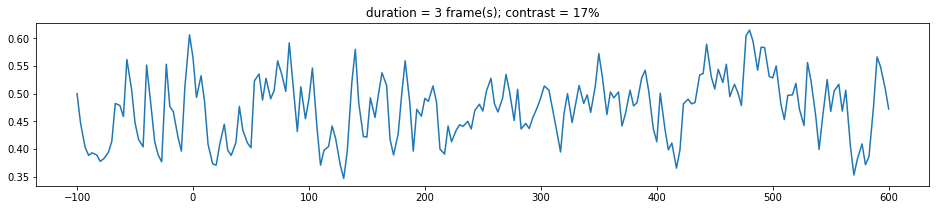

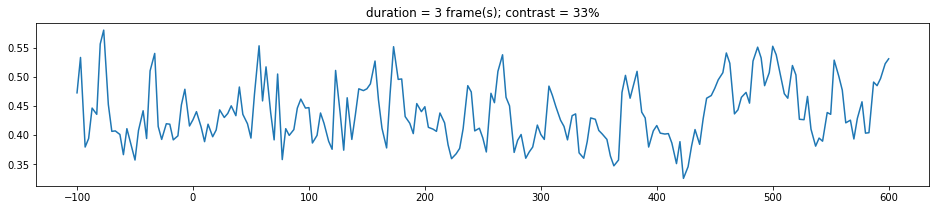

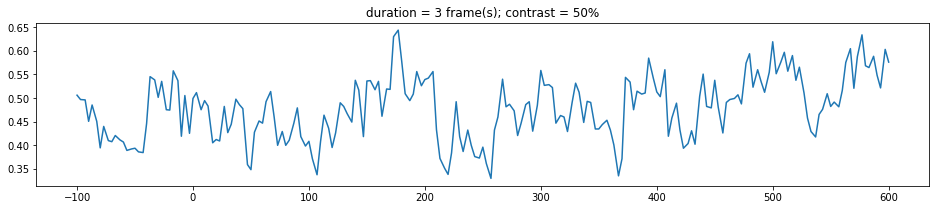

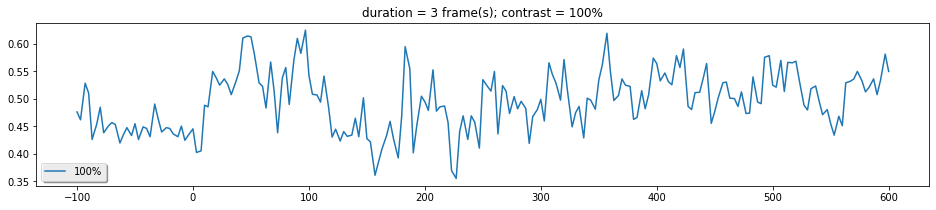

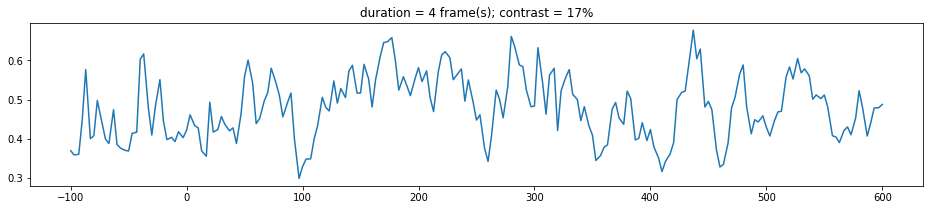

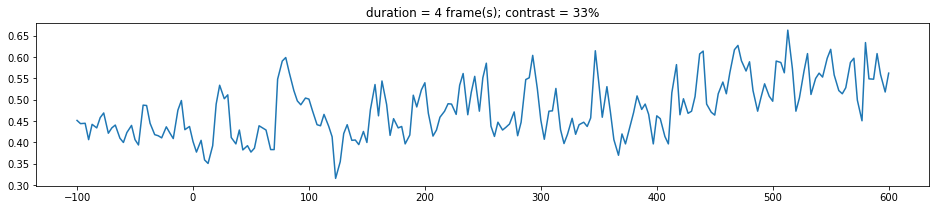

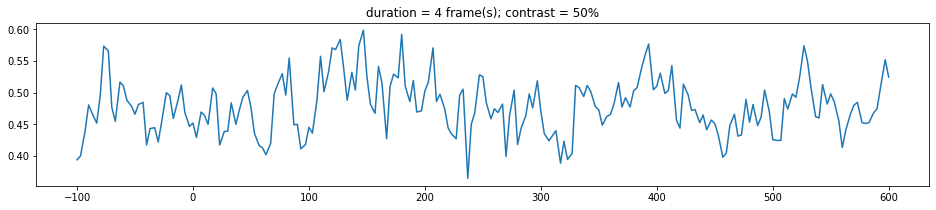

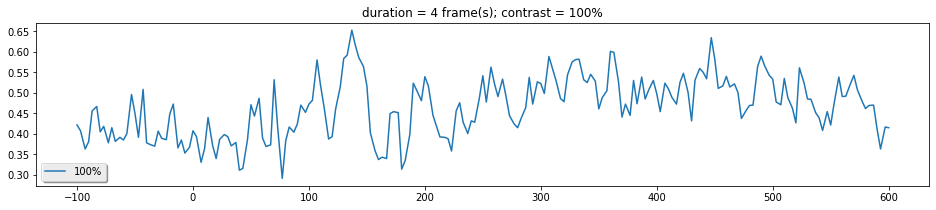

In [112]:
%matplotlib inline
for cur_dur in range(len(all_durs)):
#     plt.title(label='duration = ' + str(all_durs[cur_dur]) + ' frame(s)')
    for cur_cont in range(len(all_conts)):
        plt.figure(figsize=(16, 3))
        plt.title(label='duration = ' + str(all_durs[cur_dur]) + ' frame(s); contrast = ' + str(all_conts[cur_cont]) + '%')
        plt.plot(all_times, np.array(acc.loc[(all_durs[cur_dur], all_conts[cur_cont]), :]).T, label = str(all_conts[cur_cont]) + '%');
        # plt.savefig(qc_fname + '_light-sensors.pdf')
    leg = plt.legend(loc='lower left', ncol=4, shadow=True, fancybox=True)
    leg.get_frame().set_alpha(0.8)

# Debug: Single-_t_ case

In [48]:
all_durs = 4  # [1, 2, 3, 4]
all_conts = 100  # [17, 33, 50, 100]
t = 87
acc_index = pd.MultiIndex.from_product([[all_durs], [all_conts]], names=['dur', 'cont'])
acc = pd.DataFrame(np.zeros((1, len(all_times))), index=acc_index, columns=all_times)
cur_cond_str = 'dur4/cont100'
epochs_subset_df = epochs_df[epochs_df.index.get_level_values('condition').str.contains(cur_cond_str)].loc[pd.IndexSlice[:, :, t], :]

In [49]:
cur_cond_str

'dur4/cont100'

In [50]:
epochs_subset_df.head

channel                         MEG0111   MEG0112   MEG0113   MEG0121  \
condition          epoch time                                           
left/dur4/cont100  28    87   -0.532187  0.841984 -1.148955  0.347068   
                   73    87    0.001669 -1.914992  0.199287 -1.372988   
                   95    87    0.681560 -0.563295  0.765399  0.715947   
                   126   87   -0.534997 -0.710329 -0.548943 -0.427726   
right/dur4/cont100 4     87   -2.445140 -1.466747 -0.095105 -0.385865   
                   117   87   -2.531146 -4.009911  0.641970 -0.694386   
left/dur4/cont100  7     87    1.870250 -2.667666  1.255343  1.814966   
                   38    87   -0.024609 -2.712332  0.173106  2.121639   
                   66    87    1.155252  2.709733  1.329198  0.045742   
                   113   87   -1.106438 -1.024625  0.159252 -0.779633   
right/dur4/cont100 12    87   -2.004501  1.958746 -0.444742 -0.950506   
                   53    87   -2.467044 -0.818693  0.017781 -1.080679   
                   83    87   -1.424181  0.342090 -0.349939 -0.557083   
                   132   87    0.824744 -0.242949  2.631134 -0.891279   
left/dur4/cont100  12    87   -2.210444  0.320056  1.229156 -1.747855   
                   47    87   -1.010832  0.257486  1.957704 -2.186565   
                   88    87    0.394357  1.370230  1.179309  0.022699   
right/dur4/cont100 37    87    0.079109  1.405480 -0.546451  0.530361   
                   52    87   -2.948062 -0.848601  0.905544 -2.303550   
                   84    87   -1.271143  0.549636 -1.664047 -0.755663   
                   106   87   -1.914742  0.635216 -1.566875  0.919520   
                   127   87    1.415921  0.583599  0.935689 -0.444868   
left/dur4/cont100  15    87    1.317898  1.295244  0.360979  0.344869   
                   45    87   -3.880469 -0.316623  3.647417 -3.564018   
                   113   87    0.260823 -1.572899  2.478096 -1.460877   
                   142   87   -3.560856  1.774840  2.156608 -4.579022   
right/dur4/cont100 31    87    0.202418 -1.521398 -1.176886  1.344007   
                   63    87   -0.599207 -1.022918  0.574462 -0.778426   
                   80    87    3.726225  1.627503  2.110089  3.079816   
                   110   87    1.712681  1.000974 -1.810298  1.104415   
                   136   87    1.066904 -0.494127 -0.198136  1.413971   
left/dur4/cont100  5     87   -4.340701 -0.718488 -1.394131 -1.509782   
                   35    87    0.486956 -1.288249  1.198191 -0.423429   
                   55    87   -1.141342  0.275912 -0.340937 -1.132303   
                   90    87   -0.474998 -0.523845  0.468660  0.052657   
                   101   87    1.094551  0.316671  0.619263  0.253239   
                   131   87   -0.716455 -1.731380  0.884768 -0.875953   
right/dur4/cont100 2     87   -1.306531  2.323043  0.315767 -0.097370   
                   36    87   -4.106647 -0.884964  0.664081 -3.220087   
                   59    87    0.387593  2.287701 -0.246735  0.650511   
                   80    87    0.537135  1.536671  0.851919 -0.278935   
                   138   87   -0.749118  1.272843 -0.329315 -3.089111   
left/dur4/cont100  24    87   -1.304997 -0.398924  1.039750  0.117681   
                   36    87   -0.310838  1.776192 -4.003377  0.858416   
                   66    87    1.566081  0.326238  1.802500 -2.294901   
right/dur4/cont100 8     87   -0.098078 -0.796479  0.241465  0.235240   
                   31    87   -0.888137 -1.919696  1.550200 -3.636018   
                   137   87   -3.251577 -0.072449 -0.397742 -0.919303   
left/dur4/cont100  44    87   -0.294704 -0.676856 -0.505916  0.074826   
                   57    87    3.470133  0.728410  2.962499  1.384745   
                   75    87   -1.578124 -2.540743  2.414194 -2.444233   
                   136   87    1.680099  1.874986  0.745243 -0.027237   
right/dur4/cont100 13    87    0.890129 -0.044995  2.07921

In [51]:
# cur_acc = iter_times(all_times, epochs_subset_df, validate=False)  #, cur_cond_str)
# all_times = np.round(epochs_run.times * 1000).astype(int)
# epochs_subset_df_ = epochs_subset_df
# X_right = epochs_subset_df_[epochs_subset_df_.index.get_level_values('condition').str.contains('right')].loc[pd.IndexSlice[:, :, t], :]
# X_left = epochs_subset_df_[epochs_subset_df_.index.get_level_values('condition').str.contains('left')].loc[pd.IndexSlice[:, :, t], :]
X_right = epochs_df[epochs_df.index.get_level_values('condition').str.contains('right')].loc[pd.IndexSlice[:, :, t], :]
X_left = epochs_df[epochs_df.index.get_level_values('condition').str.contains('left')].loc[pd.IndexSlice[:, :, t], :]
X = np.concatenate((X_right, X_left))
y = np.concatenate((np.repeat(1, len(X_right)), np.repeat(0, len(X_left))))

In [52]:
X

array([[-1.02365007, -1.55588675,  0.97907058, ...,  0.95425321,
        -1.81877869,  0.31250099],
       [-0.65719249, -1.8822684 ,  0.09203422, ..., -0.34739062,
         0.02903462,  0.67668067],
       [-0.02227319,  0.12699574, -0.97254488, ...,  0.79429244,
        -0.30491273, -1.65491967],
       ...,
       [ 3.47013345,  0.7284099 ,  2.96249864, ..., -2.3010024 ,
        -3.85794519, -0.14223711],
       [-1.57812382, -2.54074348,  2.41419373, ...,  2.40113169,
        -4.18864063,  1.94199472],
       [ 1.68009904,  1.87498637,  0.74524303, ...,  2.68492384,
        -2.30447801, -2.37801348]])

In [53]:
np.shape(X)

(1007, 306)

In [54]:
y

array([1, 1, 1, ..., 0, 0, 0])

## New pipeline

In [55]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [56]:
# clf = svm.SVC(kernel='sigmoid')
# scores = cross_val_score(clf, X, y, cv=4)

In [57]:
# scores

In [58]:
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [62]:
acc_list = []
ss = ShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in ss.split(X):
#     print("%s %s" % (train_index, test_index))
#     print("%s %s" % (len(train_index), len(test_index)))
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    clf = svm.SVC(kernel='sigmoid', gamma=0.001, cache_size=2000).fit(X_train, y_train)
#     clf = svm.SVR(cache_size=2000).fit(X_train, y_train)  # won't work with accuracy_score
#     scores = cross_val_score(clf, X_train, y_train, cv=4)
#     print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    y_pred = clf.predict(X_test)
#     print(classification_report(y_test, y_pred))
    this_acc = accuracy_score(y_test, y_pred)
    acc_list.append(this_acc)
#     print(accuracy_score(y_test, y_pred))
print(np.mean(acc_list))

0.6237623762376238


In [63]:
clf.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 2000,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.001,
 'kernel': 'sigmoid',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [43]:
np.mean(acc_list)

0.5042857142857143

## Old pipeline

In [45]:
# acc_.append(run_svm(X, y))
cur_test_epoch = 0
X_ = X
y_ = y
preds = []
test_epoch = [X_[cur_test_epoch, :]]
print(test_epoch)
test_class = y_[cur_test_epoch]
print(test_class)
train_epochs = X_[np.arange(len(y_))!=cur_test_epoch, :]
print(train_epochs)
train_classes = y_[np.arange(len(y_))!=cur_test_epoch]
print(train_classes)
clf = svm.SVC()
clf.fit(train_epochs, train_classes)
# preds.append(clf.predict(test_epoch).item(0))
# tests.append(test_class)
# this_pred = clf.predict(test_epoch).item()
this_pred = clf.decision_function(test_epoch)
print('class = ' + str(test_class) + ' prediction = ' + str(this_pred))
iter_acc = sum(np.array(test_class) == np.array(preds)) / len(y_)
preds.append(this_pred)
#     iter_acc = sum(y_ == np.array(preds)) / len(y_)
# iter_acc = sum(np.array(test_class) == np.array(preds)) / len(y_)
#     print(iter_acc)
# print(cur_acc)
# acc.loc[(all_durs[cur_dur], all_conts[cur_cont]), :] = cur_acc

[array([-0.36956135,  0.73309373,  1.06787516, -0.75755323,  0.08489705,
        1.55960791,  0.00894992, -1.04439436,  2.36432964,  0.45551303,
        2.27344104, -0.32096662,  0.23060278,  2.52360691, -0.26085406,
        0.17762013, -0.26240576,  2.15601738,  1.9477414 ,  0.88227018,
        1.02098076,  2.71235764,  0.92814475, -0.41382401, -2.45589901,
        0.89171529,  1.32924547, -1.65028386, -0.90764129,  4.32961109,
       -1.46350941,  3.95418019, -1.16465851, -1.10256051,  4.34931479,
        0.10169362, -0.06588309,  1.1348421 ,  0.30331055, -0.00723888,
       -1.48845733,  0.87922055,  0.41411137, -2.61283308,  1.08089786,
        0.31051695,  0.82107578,  0.6177865 , -2.98149601, -0.86486361,
        1.69392695, -2.59793124, -2.70112497,  1.40536888, -3.19943117,
       -0.10398802, -2.53076745, -3.38371282, -1.40825588, -0.0995284 ,
       -2.51236648, -0.60546487, -1.67164513, -0.93175466, -3.39756426,
       -1.13540022,  0.41402291, -0.71647768, -1.54760779, -1.1

In [112]:
preds = []
tests = []
for cur_test_epoch in range(len(y_)):
    test_epoch = [X_[cur_test_epoch, :]]
    test_class = y_[cur_test_epoch]
    train_epochs = X_[np.arange(len(y_))!=cur_test_epoch, :]
    train_classes = y_[np.arange(len(y_))!=cur_test_epoch]
    clf = svm.SVC(kernel='poly')  # kernel='linear':43% vs. kernel='poly':41%
    clf.fit(train_epochs, train_classes)
#     preds.append(clf.predict(test_epoch).item(0))
    tests.append(test_class)
    this_pred = clf.predict(test_epoch).item()
#     this_pred = clf.decision_function(test_epoch)
    print('class = ' + str(test_class) + ' prediction = ' + str(this_pred))
    preds.append(this_pred)
#     iter_acc = sum(y_ == np.array(preds)) / len(y_)
print(sum(np.array(tests) == np.array(preds)) / len(y_))
#     print(iter_acc)

class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 1
class = 1 prediction = 0
class = 1 prediction = 1
class = 1 prediction = 1
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 0 prediction = 0
class = 0 prediction = 0
class = 0 prediction = 0
class = 0 prediction = 0
class = 0 prediction = 0
class = 0 prediction = 0
class = 0 prediction = 1
class = 0 prediction = 1
class = 0 prediction = 0
class = 0 prediction = 0
class = 0 prediction = 0
class = 0 prediction = 1


# Debug: Single-condition poly

## Validation

In [115]:
all_durs = [4]  # [1, 2, 3, 4]
all_conts = [100]  # [17, 33, 50, 100]
acc_index = pd.MultiIndex.from_product([all_durs, all_conts], names=['dur', 'cont'])
acc = pd.DataFrame(np.zeros((len(all_durs)*len(all_conts), len(all_times))),
                   index=acc_index, columns=all_times)
for cur_dur in range(len(all_durs)):
    for cur_cont in range(len(all_conts)):
        cur_cond_str = 'dur' + str(all_durs[cur_dur]) + '/' + 'cont' + str(all_conts[cur_cont]).zfill(3)
        print(cur_cond_str, end=' ')
        epochs_subset_df = epochs_df[epochs_df.index.get_level_values('condition').str.contains(cur_cond_str)]
        cur_acc = iter_times(all_times, epochs_subset_df, validate=True)  #, cur_cond_str)
        acc.loc[(all_durs[cur_dur], all_conts[cur_cont]), :] = cur_acc

dur4/cont100 [==========]


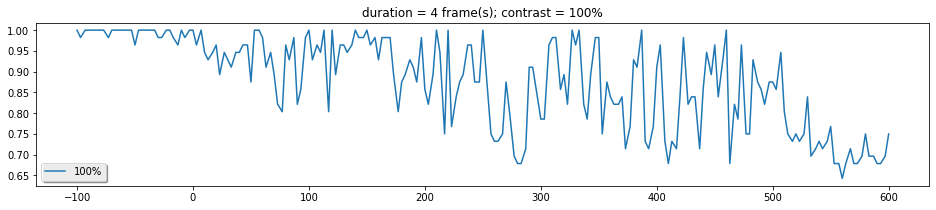

In [116]:
%matplotlib inline
for cur_dur in range(len(all_durs)):
#     plt.title(label='duration = ' + str(all_durs[cur_dur]) + ' frame(s)')
    for cur_cont in range(len(all_conts)):
        plt.figure(figsize=(16, 3))
        plt.title(label='duration = ' + str(all_durs[cur_dur]) + ' frame(s); contrast = ' + str(all_conts[cur_cont]) + '%')
        plt.plot(all_times, np.array(acc.loc[(all_durs[cur_dur], all_conts[cur_cont]), :]).T, label = str(all_conts[cur_cont]) + '%');
        # plt.savefig(qc_fname + '_light-sensors.pdf')
    leg = plt.legend(loc='lower left', ncol=4, shadow=True, fancybox=True)
    leg.get_frame().set_alpha(0.8)

## Training

In [120]:
all_durs = [4]  # [1, 2, 3, 4]
all_conts = [100]  # [17, 33, 50, 100]
acc_index = pd.MultiIndex.from_product([all_durs, all_conts], names=['dur', 'cont'])
acc = pd.DataFrame(np.zeros((len(all_durs)*len(all_conts), len(all_times))),
                   index=acc_index, columns=all_times)
for cur_dur in range(len(all_durs)):
    for cur_cont in range(len(all_conts)):
        cur_cond_str = 'dur' + str(all_durs[cur_dur]) + '/' + 'cont' + str(all_conts[cur_cont]).zfill(3)
        print(cur_cond_str, end=' ')
        epochs_subset_df = epochs_df[epochs_df.index.get_level_values('condition').str.contains(cur_cond_str)]
        cur_acc = iter_times(all_times, epochs_subset_df, validate=False)  #, cur_cond_str)
        acc.loc[(all_durs[cur_dur], all_conts[cur_cont]), :] = cur_acc

dur4/cont100 [==========]


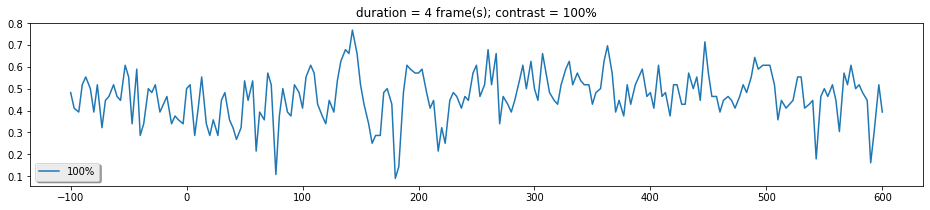

In [121]:
%matplotlib inline
for cur_dur in range(len(all_durs)):
#     plt.title(label='duration = ' + str(all_durs[cur_dur]) + ' frame(s)')
    for cur_cont in range(len(all_conts)):
        plt.figure(figsize=(16, 3))
        plt.title(label='duration = ' + str(all_durs[cur_dur]) + ' frame(s); contrast = ' + str(all_conts[cur_cont]) + '%')
        plt.plot(all_times, np.array(acc.loc[(all_durs[cur_dur], all_conts[cur_cont]), :]).T, label = str(all_conts[cur_cont]) + '%');
        # plt.savefig(qc_fname + '_light-sensors.pdf')
    leg = plt.legend(loc='lower left', ncol=4, shadow=True, fancybox=True)
    leg.get_frame().set_alpha(0.8)